# Identifying fraudulent Transactions 

This dataset loosely resembles real transactional data from capital one credit card customers, but the entities and relations within are purely fictional. No persons, places, or things lost their identity in the making of this dataset.

## Objdective: 
The goal is to build a predictive model to determine whether a given transaction will be fraudulent or not. 
Also, analyze reversed and multi-swipe transactions to identify patterns, outliers, and significant trends across merchants and account numbers over time.

In [2]:
import jsonlines
import pandas as pd
from datetime import datetime

# Read the line-delimited JSON file
data = []
with jsonlines.open("/Users/shivanikanodia/Downloads/transactions.txt") as reader:
    for obj in reader:
        data.append(obj)

# Convert to DataFrame
data = pd.DataFrame(data)

# View the DataFrame
print(data)     # Print the entire DataFrame 

       accountNumber customerId  creditLimit  availableMoney  \
0          737265056  737265056       5000.0         5000.00   
1          737265056  737265056       5000.0         5000.00   
2          737265056  737265056       5000.0         5000.00   
3          737265056  737265056       5000.0         5000.00   
4          830329091  830329091       5000.0         5000.00   
...              ...        ...          ...             ...   
786358     732852505  732852505      50000.0        48904.96   
786359     732852505  732852505      50000.0        48785.04   
786360     732852505  732852505      50000.0        48766.15   
786361     732852505  732852505      50000.0        48716.72   
786362     732852505  732852505      50000.0        48666.83   

        transactionDateTime  transactionAmount         merchantName  \
0       2016-08-13T14:27:32              98.55                 Uber   
1       2016-10-11T05:05:54              74.51          AMC #191138   
2       2016-11-08

In [3]:
print(data.info())  # Print a summary of the DataFrame (columns, types, etc.) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

Transaction dataset has total of 786363 entries, with total of 29 coulmns.
It has both object float and boolean data types which indicates data is mix of different set values. 

In [8]:
# Display the first few rows of customerId and accountNumber columns
print("First few rows of customerId and accountNumber:")
print(data[['customerId', 'accountNumber']].head())

# Check if the columns are identical
are_identical = data['customerId'].equals(data['accountNumber'])
print(f"Are 'customerId' and 'accountNumber' identical? {are_identical}") 
data[['customerId', 'accountNumber']].tail() 

First few rows of customerId and accountNumber:
  customerId accountNumber
0  737265056     737265056
1  737265056     737265056
2  737265056     737265056
3  737265056     737265056
4  830329091     830329091
Are 'customerId' and 'accountNumber' identical? True


,customerId,accountNumber
786358,732852505,732852505
786359,732852505,732852505
786360,732852505,732852505
786361,732852505,732852505
786362,732852505,732852505


I have dropped CustomerID column as it contains data which is identical to the AccountNumber column. Retaining both columns does not add value to the analysis and may lead to redundancy in further analysis. 

In [10]:
# Check remaining missing values
missing_summary = data.isnull().sum()
print(missing_summary) 

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


The dataset has no null values and is completly clean. However there are some coulmns which are empty with no data at all for coulmns like echobuffer, merchantstate and merchantZip which I will remove from analysis as they dont add value in predicting fraudulent activity. 

Coulmns like echoBuffer, MerchantCity , merchantState, merchantZip, postOnPremises, recurringAuthInd are all blank coulmns with no data int it, so we can drop the coulmns as it does not add any contribution towards our data analysis. 

In [10]:
data.describe() 

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


## From the above stastical summary we can see infer few things below:

Analyzing the dataset reveals several key insights into user behavior and financial patterns. 
The average credit limit stands at $10,759, indicating that most users possess mid-level credit capacities. Interestingly, the mean available balance is lower than the credit limit, suggesting that users are actively utilizing their credit lines, with some even exceeding their limits, as evidenced by negative balances. 
Transaction analysis shows an average amount of $136, with 75% of transactions below $191, highlighting a tendency towards smaller purchases.
The positive skewness in transaction amounts further underscores that while most transactions are modest, there are occasional higher-value expenditures. Additionally, the presence of negative account numbers warrants further investigation to ensure data integrity and accuracy.

In [16]:

df_transactions = pd.DataFrame(data)

# Convert transactionDateTime to datetime
df_transactions['transactionDateTime'] = pd.to_datetime(df_transactions['transactionDateTime'])

# 1. Extract Time of Day (Hour)
df_transactions['transaction_hour'] = df_transactions['transactionDateTime'].dt.hour

# 2. Extract Transaction Date
df_transactions['transaction_date'] = df_transactions['transactionDateTime'].dt.date

# Display the DataFrame with new features
print(df_transactions) 


       accountNumber customerId  creditLimit  availableMoney  \
0          737265056  737265056       5000.0         5000.00   
1          737265056  737265056       5000.0         5000.00   
2          737265056  737265056       5000.0         5000.00   
3          737265056  737265056       5000.0         5000.00   
4          830329091  830329091       5000.0         5000.00   
...              ...        ...          ...             ...   
786358     732852505  732852505      50000.0        48904.96   
786359     732852505  732852505      50000.0        48785.04   
786360     732852505  732852505      50000.0        48766.15   
786361     732852505  732852505      50000.0        48716.72   
786362     732852505  732852505      50000.0        48666.83   

       transactionDateTime  transactionAmount         merchantName acqCountry  \
0      2016-08-13 14:27:32              98.55                 Uber         US   
1      2016-10-11 05:05:54              74.51          AMC #191138   

From the TransactionDateTime feature,  extracted the transaction hour and transaction date. These components are crucial for detecting fraudulent activities that may occur during specific peak hours, durations, or days. By breaking down the timestamp into these elements,  aim is to identify temporal patterns associated with fraudulent behavior.

In [18]:
df = df_transactions.drop('transactionDateTime', axis=1) 

In [20]:
unique_counts = df.nunique() 
unique_counts 

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521916
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5246
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud                          2
datetime            

There are 5000 Unique AccountNumber and 5 different regions and locations and 19 potential different merchants. 
There are 6 unique posEntryMode which indicates that there could be Manual Entry,  The transaction was processed using a card reader, online platform and could be via recurring billing.

In [22]:
# Data Structure and Summary
print("Number of records:", df.shape[0])
print("Number of fields per record:", df.shape[1]) 

Number of records: 786363
Number of fields per record: 31


In [24]:

#Reversed Transaction

reversed_transcations = df[df["transactionType"]=="REVERSAL"]
print("Number of reversed_transcations ",reversed_transcations.shape[0])
print("Total value of reversed_transcations ${}".format(round(sum(reversed_transcations.transactionAmount),2))) 

Number of reversed_transcations  20303
Total value of reversed_transcations $2821792.5


In [72]:
#MultiSwipe Transaction
#Logic for a MultiSwipe transaction ==> accountNumber,date, merchantName and Hour should be same

multiswipe_transcations = pd.DataFrame(df.groupby(["accountNumber","transaction_date","merchantName","transaction_hour"]).head())
print("Number of multiswipe_transcations",df.shape[0] - multiswipe_transcations.shape[0])
print("Total Amount for Multiswipe Transaction ",sum(df.transactionAmount) - sum(multiswipe_transcations.transactionAmount),"$") 

Number of multiswipe_transcations 6
Total Amount for Multiswipe Transaction  1044.109999999404 $


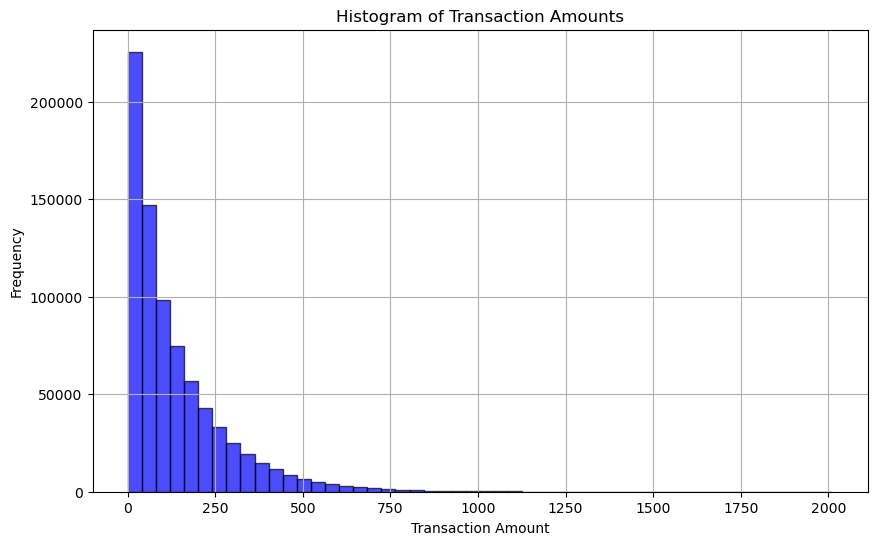

Transaction Amount Summary:
count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64


In [74]:
import matplotlib.pyplot as plt

# Plot histogram for transactionAmount
plt.figure(figsize=(10, 6))
plt.hist(df["transactionAmount"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Statistical description of transactionAmount
transaction_stats = df["transactionAmount"].describe()
print("Transaction Amount Summary:")
print(transaction_stats)  


The histogram above illustrates the distribution of transaction amounts and their frequency. The data shows that transaction peaks occur predominantly for amounts less than 250, with a mean transaction value of 136. Additionally, 75% of users spend 191 or less on their transactions, indicating that the majority of users make transactions below 200

In [76]:

# Remove the specified columns
columns_to_remove = ['cardLast4Digits', 'cardCVV', 'merchantCategoryCode','dateOfLastAddressChange', 'transactionDateTime', 'echoBuffer', 'enteredCVV','merchantCity', 'posConditionCode','currentExpDate', 'merchantState','merchantZip','posOnPremises','recurringAuthInd']
df_cleaned = df.drop(columns=columns_to_remove, errors='ignore') 

# Convert non-numeric columns to numeric or datetime
for col in df_cleaned.select_dtypes(include=['object']).columns:
    if 'date' in col.lower():
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce').astype('int64') // 10**9  # Convert to Unix timestamp
    else:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')        
df_cleaned 

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,accountOpenDate,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,datetime,transaction_hour,transaction_date
0,737265056,737265056,5000.0,5000.00,98.55,2086,4,4,1,1426291200,2,0.00,0,0,False,2016-08-13 14:27:32,14,1471046400
1,737265056,737265056,5000.0,5000.00,74.51,27,4,4,3,1426291200,2,0.00,1,0,False,2016-10-11 05:05:54,5,1476144000
2,737265056,737265056,5000.0,5000.00,7.47,1305,4,4,3,1426291200,2,0.00,0,0,False,2016-11-08 09:18:39,9,1478563200
3,737265056,737265056,5000.0,5000.00,7.47,1305,4,4,3,1426291200,2,0.00,0,0,False,2016-12-10 02:14:50,2,1481328000
4,830329091,830329091,5000.0,5000.00,71.18,2084,4,4,1,1438819200,2,0.00,1,0,False,2016-03-24 21:04:46,21,1458777600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,119.92,1061,4,4,5,1345680000,2,1095.04,0,0,False,2016-12-22 18:44:12,18,1482364800
786359,732852505,732852505,50000.0,48785.04,18.89,2479,4,4,3,1345680000,2,1214.96,0,0,False,2016-12-25 16:20:34,16,1482624000
786360,732852505,732852505,50000.0,48766.15,49.43,1061,4,4,1,1345680000,2,1233.85,0,0,False,2016-12-27 15:46:24,15,1482796800
786361,732852505,732852505,50000.0,48716.72,49.89,2487,4,4,3,1345680000,2,1283.28,0,0,False,2016-12-29 00:30:55,0,1482969600


In [78]:
data_new = df_cleaned.apply(pd.to_numeric, errors='coerce') 

In [84]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

categorical = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'transactionType', 'cardPresent', 'expirationDateKeyInMatch']

for feature in categorical:
    
    X_train[feature] = labelEncoder.fit_transform(X_train[feature])
    
    X_test[feature] = labelEncoder.transform(X_test[feature]) 

In [88]:
from imblearn.over_sampling import SMOTE

from collections import Counter

counter = Counter(y_train)

print('before smoting: ', counter)

smt = SMOTE()

X_train, y_train = smt.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After smoting: ', counter) 

before smoting:  Counter({False: 619166, True: 9924})
After smoting:  Counter({False: 619166, True: 619166})


In [93]:
from sklearn.tree import DecisionTreeClassifier
# set tuning paramters

tree = DecisionTreeClassifier(max_depth=5, criterion="entropy", random_state=7) 

# Fitting model to train set

tree.fit( X_train, y_train) 

# Checking for overfitting and underfitting

print(" Accuracy on training set: ",  tree.score( X_train, y_train)) 

print(" Accuracy on test set: ", tree.score( X_test, y_test)) 

 Accuracy on training set:  0.984224832694845
 Accuracy on test set:  0.9841485824013022


I have implemented Random Forest was chosen due to its ability to handle categorical and numerical data, and effectiveness in capturing non-linear relationships.
Also, It provides great tool of feature importance, which helps understand the key drivers of fradulent trnsactions and would help us to implement potential solutions and minimize the risk. 
Lastly, to see whether a given transaction will be fraudulent or not in classification problems, Random Forest is highly accurate and scalable for medium-sized datasets.

Transaction Data is highly imbalanced and to Handled imbalances in the dataset I used SMOTE to improve model performance.


TransactionAmount: Significant for understanding spending patterns.
TransactionDateTime: Temporal trends provided insights into peak fraudulent activities.
PostEntryMode: Helped identify suspicious methods of transaction entry.
MerchantName: Revealed specific merchants prone to fraud.

Feature Transformation:

Questions I Have? 
Are there specific thresholds or business rules for flagging transactions as fraudulent beyond model predictions?
How will the model predictions be used operationally? (e.g., real-time fraud detection or periodic reporting)
                                              
What I Would Do Next With More Time?

I would have used more feautures like payment Type, ProentryMode and different time formarts to see if there are fraudulent actities for specfic times or days. 
I would have used expiration date by match to signigicantly find fraudlent transactions as 

Hyperparameter Tuning:
Perform grid search or randomized search to optimize model parameters for better performance.
Use unsupervised learning methods like clustering to detect anomalous transactions
Create an interactive dashboard to present insights and predictions to stakeholders.


In [65]:
# Feature Importance (optional)
feature_importance = rf_model.feature_importances_
for name, importance in zip(X.columns, feature_importance):
    print(f"{name}: {importance:.4f}") 

accountNumber: 0.0549
customerId: 0.0546
creditLimit: 0.0223
availableMoney: 0.1140
transactionAmount: 0.1280
merchantName: 0.1158
acqCountry: 0.0026
merchantCountryCode: 0.0033
posEntryMode: 0.0225
posConditionCode: 0.0141
merchantCategoryCode: 0.0000
currentExpDate: 0.0000
accountOpenDate: 0.0000
dateOfLastAddressChange: 0.0000
cardCVV: 0.0516
enteredCVV: 0.0526
cardLast4Digits: 0.0543
transactionType: 0.0048
echoBuffer: 0.0000
currentBalance: 0.1125
merchantCity: 0.0000
merchantState: 0.0000
merchantZip: 0.0000
cardPresent: 0.0058
posOnPremises: 0.0000
recurringAuthInd: 0.0000
expirationDateKeyInMatch: 0.0002
datetime: 0.1144
transaction_hour: 0.0716
transaction_date: 0.0000
